In [32]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, RocCurveDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/kaggle/input/gym-customers-features-and-churn/gym_churn_us.csv


## Load data set

In [33]:
df = pd.read_csv("/kaggle/input/gym-customers-features-and-churn/gym_churn_us.csv")
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## Data Cleaning

In [34]:
df.shape

(4000, 14)

In [35]:
df.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
       'Churn'],
      dtype='object')

In [36]:
print("Data Info:")
df.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-n

In [37]:
print("\nNumerical Features Statistics:")
print(df.describe())


Numerical Features Statistics:
            gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       Contract_period  Group_visits          Age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   


## Selected Features

In [38]:
X = df[[
    "Avg_class_frequency_total",
    "Avg_class_frequency_current_month",
    "Lifetime",
    "Month_to_end_contract",
    "Contract_period"
]]
y = df["Churn"]

## Select best model with pipeline

In [39]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

cv_results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", model)
    ])
    scores = cross_val_score(pipeline, X, y, cv=5, scoring="accuracy")
    cv_results[name] = (np.mean(scores), np.std(scores))

print("\nCross-validation results:")
for model, (mean_acc, std_acc) in cv_results.items():
    print(f"{model}: {mean_acc:.3f} ± {std_acc:.3f}")


Cross-validation results:
Logistic Regression: 0.911 ± 0.010
Random Forest: 0.925 ± 0.010
Gradient Boosting: 0.926 ± 0.009
SVM: 0.916 ± 0.010


## Splitting data, Training


In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
from sklearn.pipeline import Pipeline
import joblib

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", GradientBoostingClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

joblib.dump(pipeline, "gym_churn_model.pkl")

['gym_churn_model.pkl']

## Model Prediction

In [41]:
y_pred = pipeline.predict(X_test)

## Model Evaluation

In [42]:
acc = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", acc)

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Stay", "Churn"]))


Test Accuracy: 0.935

Classification Report:
               precision    recall  f1-score   support

        Stay       0.95      0.96      0.96       588
       Churn       0.88      0.87      0.88       212

    accuracy                           0.94       800
   macro avg       0.92      0.91      0.92       800
weighted avg       0.93      0.94      0.93       800



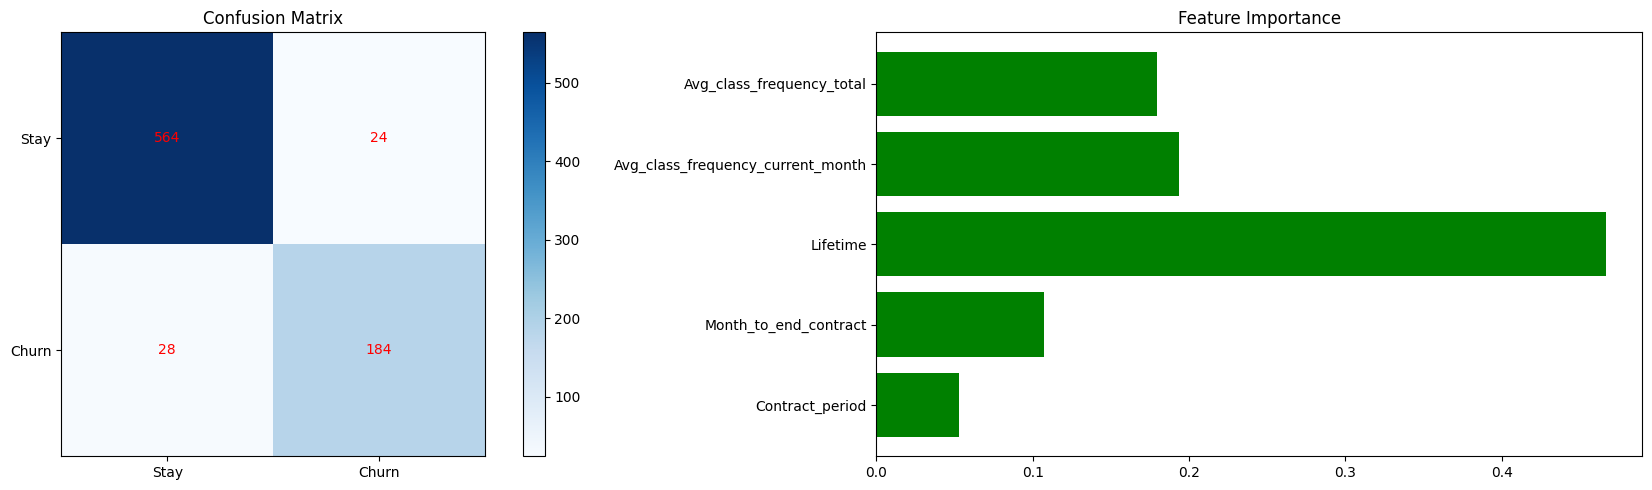

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
cm = confusion_matrix(y_test, y_pred)
im = axs[0].imshow(cm, cmap="Blues")
axs[0].set_title("Confusion Matrix")
axs[0].set_xticks([0, 1]); axs[0].set_yticks([0, 1])
axs[0].set_xticklabels(["Stay", "Churn"]); axs[0].set_yticklabels(["Stay", "Churn"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axs[0].text(j, i, cm[i, j], ha="center", va="center", color="red")
fig.colorbar(im, ax=axs[0])


# Feature Importance
importances = pipeline.named_steps["model"].feature_importances_
axs[1].barh(X.columns, importances, color="green")
axs[1].set_title("Feature Importance")
axs[1].invert_yaxis()

plt.tight_layout()
plt.show()